In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks, filtfilt, firwin, fftconvolve, correlate 
from signal_processor import perturbation_L, voice_parameters, voice_segmentation, WM_method
import copy

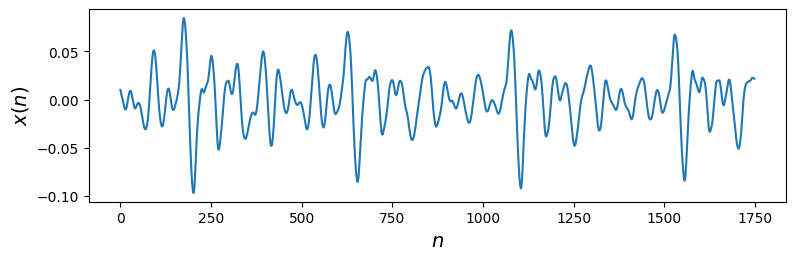

In [2]:
# загрузка аудиофайла
# data, fs = sf.read('010.wav', dtype='float32')
data, fs = sf.read('117_a.wav', dtype='float32')

fig, ax = plt.subplots(figsize=(9,2.5),dpi=100) # figsize=(7,5) 
plt.rcParams.update({'font.size': 14})

ax.plot(data[:1750])
ax.set_xlabel("$ n $",fontsize=14);
ax.set_ylabel("$ x(n) $",fontsize=14);
# plt.legend()

# image_name = f'speech_example.jpg'
# fig.savefig(image_name, format='jpg', dpi=200, bbox_inches='tight', pad_inches = 0.2) 

# Voice segmentation

In [3]:
def voice_segmentation(data,fs):
    N = 2048
    x = data[:N]
    
    r_xx = np.zeros((2*N)).astype(float)

    x_ = np.zeros((2*N))
    x_[:N] = x
    X = np.fft.fft(x_)
    r_xx = np.real(np.fft.ifft(X*np.conj(X)))
    r_xx = r_xx[:N]

    peaks, _ = find_peaks(r_xx)
    
    max_peak = peaks[0]
    for i in range(1, len(peaks)):
        if r_xx[peaks[i]] > r_xx[max_peak]:
            max_peak = peaks[i]
    
    nyq = 0.5*fs    
    T0 = max_peak   
    T0 = T0/fs      # seconds
    F0 = 1.0/(T0)   
    cutoff = 1.5*F0/nyq 
    N_filter = 401  

    taps = firwin(N_filter, cutoff, fs=fs, window=('chebwin',120))
 
    filtered_signal = fftconvolve(data, taps, mode='full')     
    filtered_signal = filtered_signal[(N_filter-1)//2:]

    zero_crossings = np.where(np.diff(np.sign(filtered_signal[:len(data)])))[0]

    positive_zero_crossings_left = []

    for i in zero_crossings:    
        if (filtered_signal[i]<0) and (filtered_signal[i+1]>0):        
            positive_zero_crossings_left.append(i)
            
    return positive_zero_crossings_left

# WM method

In [3]:
def WM_method(x, x_filtered, fs, I_N):
    """
    x – input signal
    fs – sampling frequency
    I_N – rough marking of the input signal
    """
    PERC = 0.05
    Nc = len(I_N)
    F0 = np.zeros(Nc - 3)
    P = np.zeros(Nc - 2, dtype=int)

    # Find the minimum point and set P[0]
    P[0] = np.argmin(x_filtered[I_N[0]:I_N[1]]) + I_N[0]

    for i in range(1, Nc - 2):
        P[i] = I_N[i] + (P[i - 1] - I_N[i - 1])
        J1 = P[i] - round(PERC * (P[i] - P[i - 1]))
        J2 = P[i] + round(PERC * (P[i] - P[i - 1]))
        search_complete = False

        while not search_complete:
            err_min = np.inf
            Jm = None

            for j in range(J1, J2 + 1):
                err_cur = ERR(j, P, i, x)
                if err_cur < err_min:
                    err_min = err_cur
                    Jm = j

            if Jm == J1:
                J1 = J1 - round(0.5 * (J2 - J1))
            elif Jm == J2:
                J2 = J2 + round(0.5 * (J2 - J1))
            else:
                search_complete = True

        P[i] = Jm

        # Calculate the error at Jm+1, Jm-1, and Jm
        err_Jm_plus1, err_Jm_minus1, err_Jm = ERR(Jm+1, P, i, x), ERR(Jm-1, P, i, x), ERR(Jm, P, i, x)
        delta = -0.5 * ((err_Jm_plus1 - err_Jm_minus1) / (err_Jm_plus1 - 2 * err_Jm + err_Jm_minus1))

        # Frequency calculation
        F0[i - 1] = fs / (P[i] - P[i - 1] + delta)

    return F0,P

def ERR(j, P, i, buff):
    """
    Calculate error for current j, given P and i.
    """
    # sum_error = 0
    err_cur = np.mean((buff[j:j + (j - P[i - 1])] - buff[P[i - 1]:j])**2)
    # for k in range(P[i - 1], j):
    #     sum_error += (buff[k + (j - P[i - 1])] - buff[k]) ** 2
    # err_cur = (1 / (j - P[i - 1])) * sum_error
    return err_cur

## Calculate Autocorrelation function - $r_{xx}(\ell)$

In [4]:
N = 2048
x = data[:N] 

# Autocorrelation: time-domain calculation (slow)
lags = np.array(range(0, N))
# # r_xx = np.zeros_like(lags).astype(float)
# # for lag in lags:
# #     tmp_sum = 0
# #     for n in range(N):
# #         if ((n+lag)<N) and ((n+lag)>=0):
# #             tmp_sum = tmp_sum + x[n]*x[n+lag]          
# #     r_xx[lag] = tmp_sum

# Autocorrelation: frequency-domain calculation (fast)
x_ = np.zeros((2*N))
x_[:N] = x
X = np.fft.fft(x_)
r_xx = np.real(np.fft.ifft(X*np.conj(X)))
r_xx = r_xx[:N]


# # fig, ax = plt.subplots(figsize=(5, 5)) 
# # ax.plot(r_xx) 
# # ax.set_title('Автокорреляционная функция') 
# # ax.set_xlabel('Отсчеты, n')

peaks, _ = find_peaks(r_xx)

max_peak = peaks[0]
for i in range(1, len(peaks)):
    if r_xx[peaks[i]] > r_xx[max_peak]:
        max_peak = peaks[i]

nyq = 0.5*fs    
T0 = max_peak   
T0_s = T0/fs      # seconds
F0 = 1.0/(T0_s)   
cutoff = 1.8*F0/nyq 
N_filter = np.round(1.0*T0).astype(np.int32)
N_filter = N_filter - (N_filter%2)

taps = firwin(N_filter, cutoff, fs=fs, window=('kaiser',8))

filtered_signal = fftconvolve(data, taps, mode='full')  
filtered_signal = filtered_signal[(N_filter-1)//2:]

# N_dc_filter = 2**14
# dc_fir = (1.0/N_dc_filter)*np.ones((N_dc_filter))
# dc_signal = fftconvolve(data, dc_fir, mode='full')  
# dc_signal = dc_signal[N_dc_filter//2:]

# filtered_signal = filtered_signal[:len(data)] - dc_signal[:len(data)]

signal_sign = np.sign(filtered_signal[:len(data)])
segments = np.where(np.diff(signal_sign)<0)[0] + 1

# positive_zero_crossings_left = []

# for i in zero_crossings:    
#     if (filtered_signal[i]<0) and (filtered_signal[i+1]>0):        
#         positive_zero_crossings_left.append(i)

# segments = voice_segmentation(data,fs)

### Объяснение как вычислить позиции пересечения нуля (zero crossing)

In [48]:
signal = [1, 1, 1, -1, -0.1, -1, -1, 1, 1, 1, -1,-1,-1, 1, 1]
signal = np.diff(np.sign(signal))
print(signal)
signal = np.where(signal>0)[0] + 1
print(signal)

[ 0.  0. -2.  0.  0.  0.  2.  0.  0. -2.  0.  0.  2.  0.]
[ 7 13]


In [13]:
# Применение коррекции
x = copy.copy(data)

# I_N = segments
I_N = voice_segmentation(x, fs)
F0_, P_N = WM_method(x, filtered_signal, fs, I_N)
periods = np.diff(P_N)

## Show results

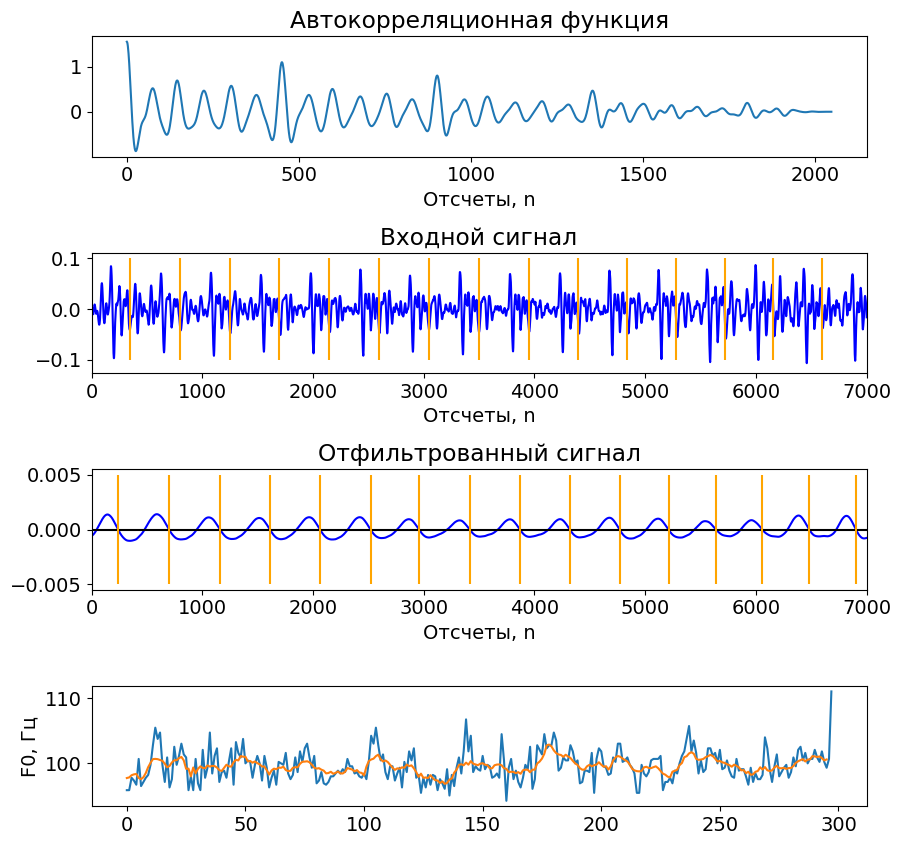

In [14]:
n_min = 0*1000
n_max = 7*1000

fig, axs = plt.subplots(nrows=4, figsize=(10, 10)) 
axs[0].plot(lags, r_xx)
# axs[0].plot(r_xx)
axs[0].set_title('Автокорреляционная функция') 
axs[0].set_xlabel('Отсчеты, n')

axs[1].plot(data[:len(data)], color='blue', label='input')
axs[1].vlines(P_N, -0.1, 0.1, color='orange', linestyle='-', label='$P_N (n)$')
axs[1].set_xlabel('Отсчеты, n')
axs[1].set_title('Входной сигнал')
# axs[1].axhline(y=0, color='black', linestyle='-')
axs[1].set_xlim(n_min, n_max)

axs[2].plot(filtered_signal[:len(data)], '-', color='blue', label='output')
axs[2].axhline(y=0, color='black', linestyle='-')
axs[2].vlines(segments, -0.005, 0.005, color='orange', linestyle='-', label='positive zero crossings')


axs[2].set_xlabel('Отсчеты, n')
axs[2].set_title('Отфильтрованный сигнал')
axs[2].set_xlim(n_min, n_max)

F0 = fs/np.diff(I_N)

axs[3].plot(F0)
axs[3].plot(F0_)
axs[3].set_ylabel('F0, Гц')

plt.subplots_adjust(hspace=0.8, wspace=0.0)
# plt.legend()
plt.show()

In [15]:
periods = []
amplitudes = []

for i in range(len(P_N)-1):
    start_idx = P_N[i]
    end_idx = P_N[i+1]
    period = end_idx - start_idx
    periods.append(period)

    # Нахождение минимального и максимального значения амплитуды в периоде
    min_amplitude = np.min(data[start_idx:end_idx])
    max_amplitude = np.max(data[start_idx:end_idx])

    # Вычисление амплитуды в периоде
    amplitude = max_amplitude - min_amplitude
    amplitudes.append(amplitude)

J1 = perturbation_L(np.array(periods), 1)
S1 = perturbation_L(np.array(amplitudes), 1)

J3 = perturbation_L(np.array(periods), 3)
S3 = perturbation_L(np.array(amplitudes), 3)

J5 = perturbation_L(np.array(periods), 5)
S11 = perturbation_L(np.array(amplitudes), 11)

print(f'J1 = {J1:2.2f}')
print(f'S1 = {S1:2.2f}')

print(f'J3 = {J3:2.2f}')
print(f'S3 = {S3:2.2f}')

print(f'J5 = {J5:2.2f}')
print(f'S11 = {S11:2.2f}')

J1 = 0.30
S1 = 4.13
J3 = 0.14
S3 = 1.85
J5 = 0.19
S11 = 4.21


# Application model

In [2]:
# data, fs = sf.read('010.wav', dtype='float32')
data, fs = sf.read('117_a.wav', dtype='float32')

I_N, x_filt = voice_segmentation(data,fs)
F0, P_N = WM_method(data, x_filt, fs, I_N)
J1, J3, J5, S1, S3, S5, S11, F0_mean, F0_sd = voice_parameters(data, P_N, F0)

print(f'J1 = {J1:2.2f}')
print(f'J3 = {J3:2.2f}')
print(f'J5 = {J5:2.2f}')

print(f'S1 = {S1:2.2f}')
print(f'S3 = {S3:2.2f}')
print(f'S5 = {S5:2.2f}')
print(f'S11 = {S11:2.2f}')

print(f'F0_mean = {F0_mean:2.2f}')
print(f'F0_sd = {F0_sd:2.2f}')

RecordingAnalyze voice_parameters: Start processing
RecordingAnalyze voice_parameters: Finish processing
J1 = 0.30
J3 = 0.14
J5 = 0.19
S1 = 4.13
S3 = 1.85
S5 = 2.59
S11 = 4.21
